In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input
import matplotlib.pyplot as plt

In [2]:
# path to data
train_dir = 'dataset/train'
val_dir = 'dataset/valid'
test_dir = 'dataset/test'

img_size = 224
batch_size = 32

In [3]:
# enhanced training data by ...
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
# read data from directory
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_size, img_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


In [5]:
# 创建 ConvNeXt 基础模型，这里设置 include_top=False，因为我们将添加自定义的全连接层
base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# input_shape = base_model.input_shape
# print("ConvNeXt 输入尺寸:", input_shape)

# 冻结基础模型的参数，以便在训练初期不对其进行更新
base_model.trainable = False

# 然后你可以构建你的模型
input_layer = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)
model = tf.keras.Model(input_layer, output_layer)

In [6]:
# 编译模型
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
epochs = 10  # 根据需要调整
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/10


/Users/xingruizhu/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712550249.402085 5950638 service.cc:145] XLA service 0x317ee74e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712550249.402427 5950638 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1712550249.510406 5950638 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 ━━━━━━━━━━━━━━━━━━━━ 791s 8s/step - accuracy: 0.0747 - loss: 3.0969 - val_accuracy: 0.3300 - val_loss: 2.7170
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 807s 8s/step - accuracy: 0.3166 - loss: 2.4546 - val_accuracy: 0.6400 - val_loss: 1.9897
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 800s 8s/step - accuracy: 0.6118 - loss: 1.9598 - val_accuracy: 0.7700 - val_loss: 1.3899
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 794s 8s/step - accuracy: 0.7361 - loss: 1.5812 - val_accuracy: 0.8300 - val_loss: 1.0192
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 799s 8s/step - accuracy: 0.8115 - loss: 1.3222 - val_accuracy: 0.9200 - val_loss: 0.7948
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 804s 8s/step - accuracy: 0.8499 - loss: 1.1169 - val_accuracy: 0.9500 - val_loss: 0.7386
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 813s 8s/step - accuracy: 0.8791 - loss: 0.9588 - val_accuracy: 0.9700 - val_loss: 0.5525
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 811s 8s/step - accuracy: 0.8967 - loss: 0.8541 - val_accuracy: 0.970

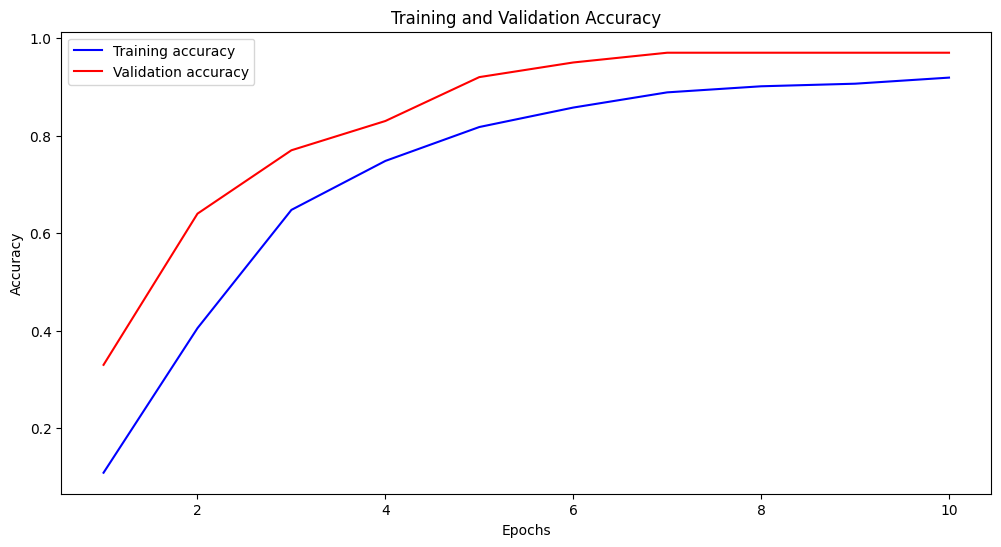

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.9633 - loss: 0.3527
Test Accuracy: 0.949999988079071


In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

model.save('model.keras')
# 评估模型


In [10]:

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input


In [11]:
# 加载训练时使用的 ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# 获取类别标签
class_labels = list(train_generator.class_indices.keys())

Found 3208 images belonging to 20 classes.


In [12]:
# 加载模型
model = load_model('model.keras')

In [13]:
# 加载要预测的图像 Albatross
img = image.load_img('ALBATROSS_3.jpg', target_size=(224, 224))  # 调整图像大小与模型输入相匹配
img_array = image.img_to_array(img)  # 将图像转换为数组
img_array = np.expand_dims(img_array, axis=0)  # 增加一个维度，因为模型预期的是批次数据
img_array = preprocess_input(img_array)

# 进行预测
ALBATROSS_3_predictions = model.predict(img_array)[0]
print(ALBATROSS_3_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[2.29111392e-04 3.83717045e-02 1.47724117e-04 1.05264124e-04
 5.31020283e-04 1.11033260e-04 7.04568229e-04 5.65169503e-05
 5.61177912e-05 9.52432573e-01 1.88790189e-04 1.39327472e-04
 4.33329260e-04 2.18563975e-04 5.05193602e-03 1.23945123e-04
 1.20835510e-04 5.34205115e-04 1.72434797e-04 2.70998979e-04]


In [14]:
# 加载要预测的图像 Coot
img = image.load_img('AMERICAN_COOT_2.jpg', target_size=(224, 224))  # 调整图像大小与模型输入相匹配
img_array = image.img_to_array(img)  # 将图像转换为数组
img_array = np.expand_dims(img_array, axis=0)  # 增加一个维度，因为模型预期的是批次数据
img_array = preprocess_input(img_array)

# 进行预测
AMERICAN_COOT_2_predictions = model.predict(img_array)[0]
print(AMERICAN_COOT_2_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
[3.4675971e-04 2.0076876e-04 1.2249151e-03 6.4436742e-04 1.6048179e-03
 3.5262469e-04 1.0166983e-03 9.6310611e-04 6.4017717e-04 7.7137782e-04
 3.1585959e-04 1.1996536e-03 2.5040046e-03 5.7506730e-04 8.5195038e-04
 9.4866613e-04 9.8430151e-01 3.7263348e-04 6.6572748e-04 4.9934210e-04]


In [15]:
# 加载要预测的图像 FLAMINGO
img = image.load_img('AMERICAN_FLAMINGO_4.jpg', target_size=(224, 224))  # 调整图像大小与模型输入相匹配
img_array = image.img_to_array(img)  # 将图像转换为数组
img_array = np.expand_dims(img_array, axis=0)  # 增加一个维度，因为模型预期的是批次数据
img_array = preprocess_input(img_array)

# 进行预测
AMERICAN_FLAMINGO_4_predictions = model.predict(img_array)[0]
print(AMERICAN_FLAMINGO_4_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
[2.3331524e-04 1.2841759e-03 5.2383129e-04 1.2976477e-03 9.8427618e-04
 6.2252086e-04 4.4360172e-04 1.7578351e-04 2.1647924e-04 2.7200865e-04
 4.3203516e-04 1.3505922e-03 1.0004921e-03 8.7647425e-04 3.2275529e-03
 3.5358345e-04 4.1234068e-04 9.8599225e-01 2.2914556e-04 7.1859533e-05]


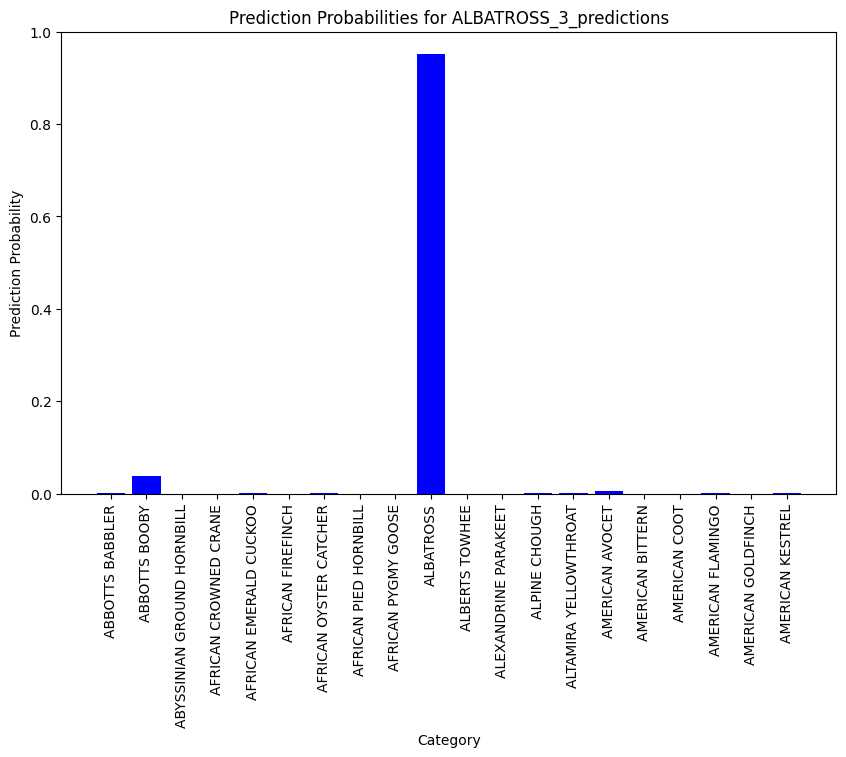

In [16]:
# 用于 "ALBATROSS_3_predictions.jpg" 的预测结果
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, ALBATROSS_3_predictions, color='blue')
plt.xlabel('Category')
plt.ylabel('Prediction Probability')
plt.title('Prediction Probabilities for ALBATROSS_3_predictions')
# 在每个柱子上添加概率值
# for bar in bars:
#     height = bar.get_height()  # 获取柱子的高度（概率值）
#     plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
#              ha='center', va='bottom')
plt.xticks(rotation=90)
plt.show()

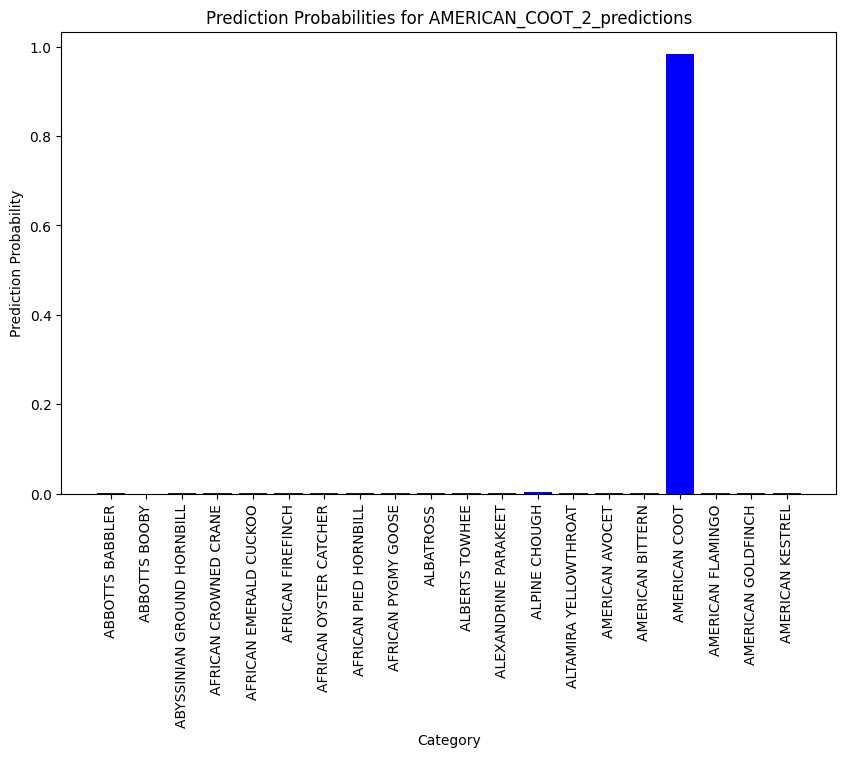

In [17]:
# 用于 "ALBATROSS_3_predictions.jpg" 的预测结果
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, AMERICAN_COOT_2_predictions, color='blue')
plt.xlabel('Category')
plt.ylabel('Prediction Probability')
plt.title('Prediction Probabilities for AMERICAN_COOT_2_predictions')
# 在每个柱子上添加概率值
# for bar in bars:
#     height = bar.get_height()  # 获取柱子的高度（概率值）
#     plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
#              ha='center', va='bottom')
plt.xticks(rotation=90)
plt.show()

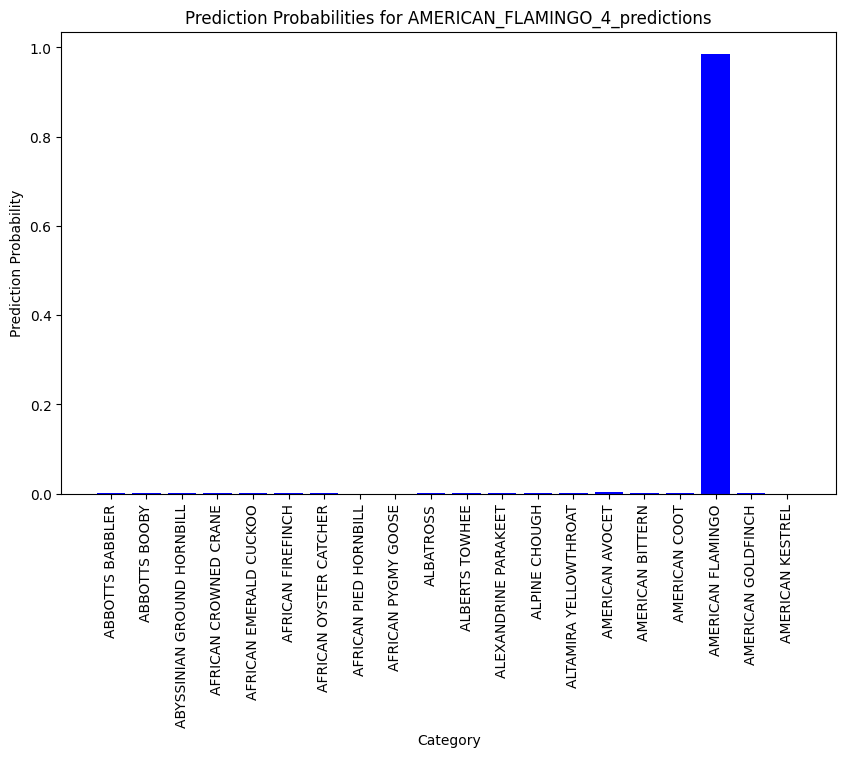

In [18]:
# 用于 "AMERICAN_FLAMINGO_4_predictions.jpg" 的预测结果
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, AMERICAN_FLAMINGO_4_predictions, color='blue')
plt.xlabel('Category')
plt.ylabel('Prediction Probability')
plt.title('Prediction Probabilities for AMERICAN_FLAMINGO_4_predictions')
# 在每个柱子上添加概率值
# for bar in bars:
#     height = bar.get_height()  # 获取柱子的高度（概率值）
#     plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
#              ha='center', va='bottom')
plt.xticks(rotation=90)
plt.show()